Import libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Load dataset

In [12]:
fraud_df = pd.read_csv('data/raw/Fraud_Data.csv')

In [13]:
ip_country_df = pd.read_csv('data/raw/IpAddress_to_Country.csv')

In [14]:
creadit_card_df = pd.read_csv('data/raw/creditcard.csv')

Handle Missing Values

In [15]:
print("Fraud missing values:\n", fraud_df.isnull().sum())
print("IP Country missing values:\n", ip_country_df.isnull().sum())
print("Credit card missing values:\n", creadit_card_df.isnull().sum())

Fraud missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
IP Country missing values:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Credit card missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Data Cleaning

Remove Duplicates

In [16]:
fraud_df.drop_duplicates(inplace=True)
creadit_card_df.drop_duplicates(inplace=True)

Fix Data Types

In [17]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].astype(np.uint32)

ip_country_df['lower_bound_ip_address'] = ip_country_df['lower_bound_ip_address'].astype(np.uint32)
ip_country_df['upper_bound_ip_address'] = ip_country_df['upper_bound_ip_address'].astype(np.uint32)


Exploratory Data Analysis

Univariate Analysis

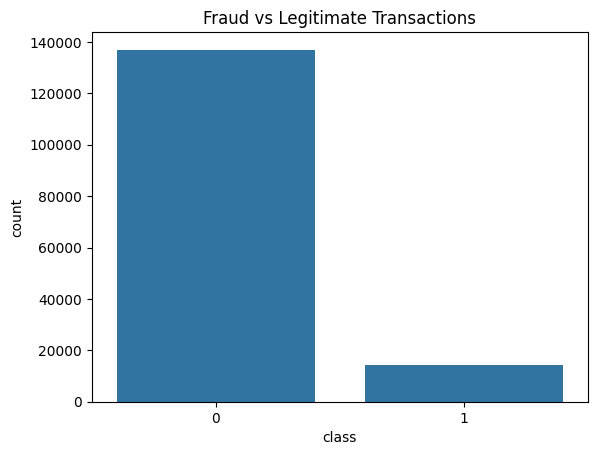

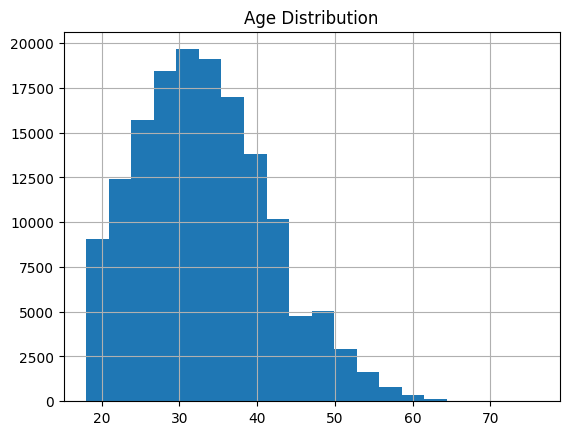

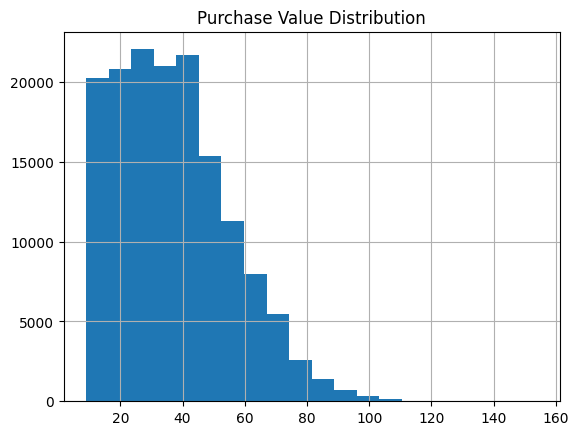

In [18]:
sns.countplot(x='class', data=fraud_df)
plt.title('Fraud vs Legitimate Transactions')
plt.show()

fraud_df['age'].hist(bins=20)
plt.title('Age Distribution')
plt.show()

fraud_df['purchase_value'].hist(bins=20)
plt.title('Purchase Value Distribution')
plt.show()

Bivariate Analysis

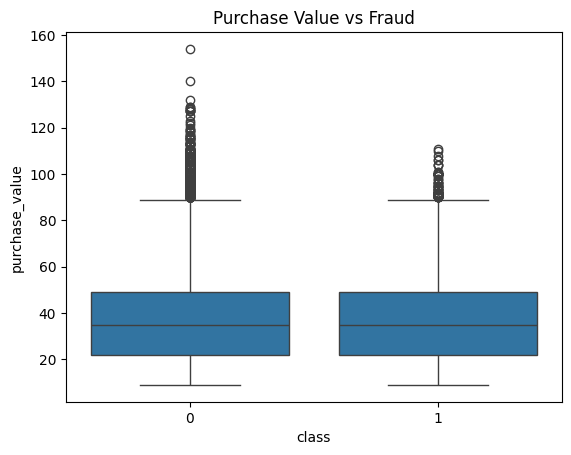

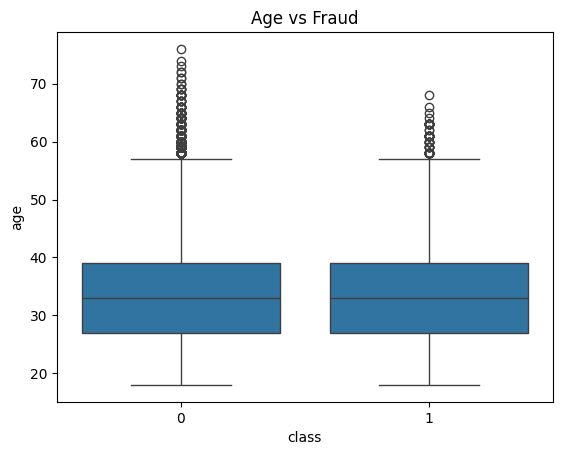

In [19]:
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title('Purchase Value vs Fraud')
plt.show()

sns.boxplot(x='class', y='age', data=fraud_df)
plt.title('Age vs Fraud')
plt.show()

Merge with IP Country Data

Convert IP to Country

In [21]:
def map_ip_to_country(ip, ip_table):
    match = ip_table[
        (ip_table['lower_bound_ip_address'] <= ip) & 
        (ip_table['upper_bound_ip_address'] >= ip)
    ]
    return match['country'].values[0] if not match.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_address'].apply(lambda x: map_ip_to_country(x, ip_country_df))


Country Analysis

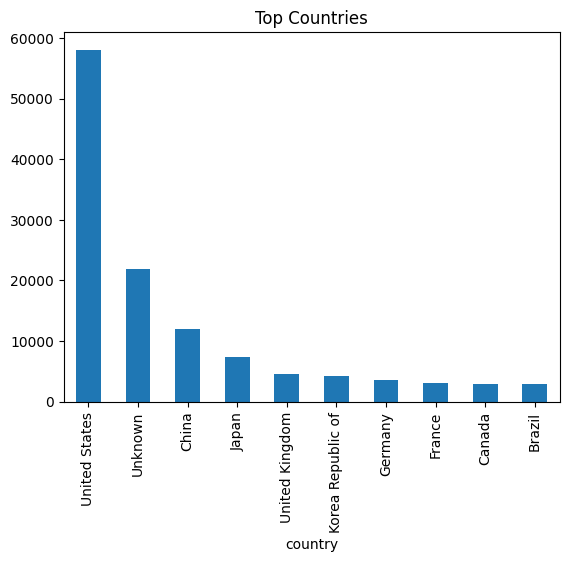

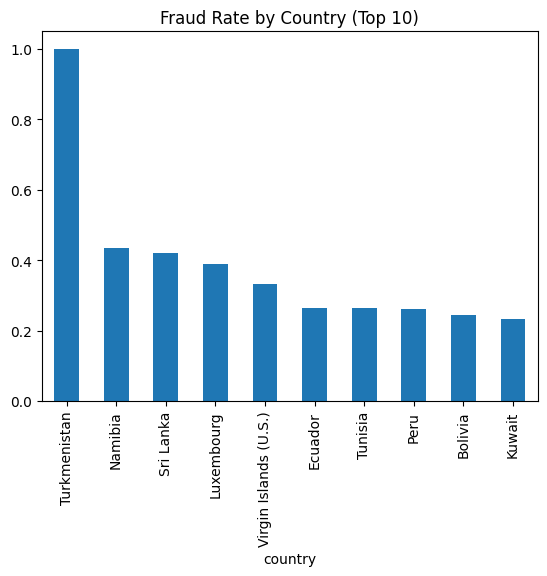

In [22]:
fraud_df['country'].value_counts().head(10).plot(kind='bar', title='Top Countries')
plt.show()

# Fraud rate by country
fraud_df.groupby('country')['class'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Fraud Rate by Country (Top 10)")
plt.show()


Feature Engineering for fraud_df

In [23]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

fraud_df['transaction_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')


Class Imbalance Handling

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


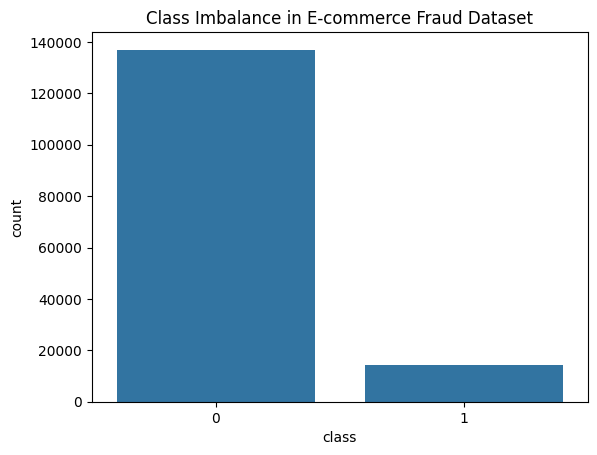

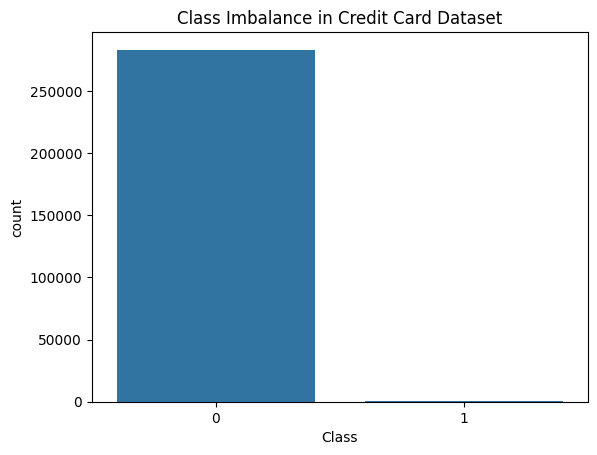

In [24]:
print(fraud_df['class'].value_counts(normalize=True))
print(creadit_card_df['Class'].value_counts(normalize=True))

# Visualize class imbalance
sns.countplot(x='class', data=fraud_df)
plt.title('Class Imbalance in E-commerce Fraud Dataset')
plt.show()

sns.countplot(x='Class', data=creadit_card_df)
plt.title('Class Imbalance in Credit Card Dataset')
plt.show()


Data Transformation

One-Hot Encoding

In [25]:
fraud_df = pd.get_dummies(fraud_df, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

Scaling Numeric Features

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fraud_df[['purchase_value', 'age', 'time_since_signup', 'transaction_count']] = scaler.fit_transform(
    fraud_df[['purchase_value', 'age', 'time_since_signup', 'transaction_count']]
)

Credit Card Scaling

In [27]:
creadit_card_df[['Time', 'Amount']] = scaler.fit_transform(creadit_card_df[['Time', 'Amount']])